### Importing the required libraries

Situation: Using the CNN's I am trying to do a classification. 

In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader, random_split, Dataset
from torch.utils.data import Dataset
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, accuracy_score

Model


In [2]:
device = "cpu" if (torch.cuda.is_available()) else "cpu"
print("Using ", device, " device")

Using  cpu  device


In [3]:
# Declaring the transform for each image (Convert to Tensor and Normalize)
# In normalization we are performing Zscore-Normalization.
# In ZscoreN, we take the std and mean of the entire dataset. We subtract each pixel in the image with the mean and divide by std.
# This way we ensure that feature of the images are more comparable and can improve the model learning.
# We used the mean and std of ImageNet as we are using it's pretrained weights for the training.
toTensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
os.path.join('/home/alien/Git/MedicalScanReport_Classification', 'MedNIST_dataset')

'/home/alien/Git/MedicalScanReport_Classification/MedNIST_dataset'

In [5]:
pwd

'/home/alien/Git/MedicalScanReport_Classification'

In [6]:
# Based on the rootDir, loading 1000 images from each class

class customDataset(Dataset):
    def __init__(self, rootDir, toTensor, numPerClass):
        self.datasetDir = rootDir
        self.numPerClass = numPerClass
        self.transform = toTensor
        self.classes = os.listdir(rootDir)
        self.imagePath = []
        self.labels = []
        print(self.classes)
        for classIdx, className in enumerate(self.classes):
            classPath = os.path.join(rootDir, className)
            imagesList = os.listdir(classPath)
            random.shuffle(imagesList)
            for idx in range(0, numPerClass):
                self.imagePath.append(os.path.join(classPath, imagesList[idx]))
                self.labels.append(classIdx)
        
    def __getitem__(self, index: int):
        cv2Image = cv2.imread(self.imagePath[index])
        image = self.transform(cv2Image)
        label = self.labels[index]
        label_tensor = torch.tensor(label)
        return image, label_tensor
        
    def __len__(self):
        return len(self.imagePath)
    
    def displayImages(self):
        fig, axes = plt.subplots(1, len(self.classes), figsize=(6,10))
        
        for classIdx, className in enumerate(self.classes):
            classPath = os.path.join(self.datasetDir, className)
            imageIdx = np.random.randint(low=0, high=len(self.labels) - 1)
            image = plt.imread(os.path.join(classPath, os.listdir(classPath)[imageIdx]))
            axes[classIdx].imshow(image)
            axes[classIdx].set_title(className)
            axes[classIdx].axis('off')
        
        plt.tight_layout()
        plt.show()

In [7]:
#Declaring the Root directory to get the MNIst dataset from google drive
rootDir = 'MedNIST_dataset'

#Creating a Class Object of CustomDataset
Dataset = customDataset(rootDir, toTensor, 1000)

['HeadCT', 'Hand', 'CXR', 'AbdomenCT', 'ChestCT', 'BreastMRI']


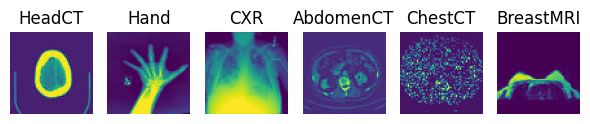

In [8]:
#Displaying the Images
Dataset.displayImages()

In [9]:
#Declaring hyper-parameters
numClasses = 6
learningRate = 0.001
numEpochs = 10
batchSize = 64

In [10]:
# Splitting data in train and test
trainDataSize = int(Dataset.__len__()*0.7)
testDataSize = int(Dataset.__len__()*0.2)
valDataSize = Dataset.__len__() - trainDataSize -  testDataSize
trainData, testData, valData = random_split(Dataset, [trainDataSize, testDataSize, valDataSize])

#Declaring the Dataloaders for train and test.
trainDataLoader = DataLoader(trainData, batch_size = batchSize,  shuffle = True)
testDataLoader = DataLoader(testData, batch_size = batchSize,  shuffle = True)
valDataLoader = DataLoader(valData, batch_size=batchSize, shuffle=True)

In [11]:
#Declaring Custom Network based on the instructions
class CustomNetwork(torch.nn.Module):
    def __init__(self):
        super(CustomNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1) #Conv Layer --> 64 x 64 x 32
        self.relu1 = nn.ReLU() #Relu Layer
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) #MaxPool layer --> 32 x 32 x 32
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1) #Conv layer ---> 32 x 30 x 30
        self.relu2 = nn.ReLU() #Relu Layer
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  #MaxPool layer ---> 32 x 16 x 16
        self.fc1 = nn.Linear(64*16*16, 128) #FC Layer
        self.relu3 = nn.ReLU() #Relu Layer
        self.fc2 = nn.Linear(128, 64) #FC Layer
        self.relu4 = nn.ReLU() #Relu Layer
        self.fc3 = nn.Linear(64, 6) #FC Layer
        self.softmax = nn.Softmax(dim=1) #Softmax to calcuate the probabilities

    def forward(self, inputImage):
        #Creating the network forward method
        x = self.conv1(inputImage)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x

In [12]:
#Declaring the model object from created custom network class
model = CustomNetwork()
print(model) #Priting the model

CustomNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu4): ReLU()
  (fc3): Linear(in_features=64, out_features=6, bias=True)
  (softmax): Softmax(dim=1)
)


In [13]:
model.to(device)
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learningRate)


trainLossList = []
trainAccuracyList = []
valLossList = []
valAccuracyList = []

for epoch in range(numEpochs):
    model.train()
    totalTrainLoss = 0.0
    totalTrainAcc = 0.0
    correctTrainPredictions = 0
    totalSamples = 0

    for i, (images, labels) in enumerate(trainDataLoader):
        #print(images.shape)
        images = images.to(device)
        labels = labels.to(device)

        # Forward Pass
        trainOutput = model(images)
        trainLoss = criteria(trainOutput, labels)
        
        # Backward Propagation
        optimizer.zero_grad()
        trainLoss.backward()
        optimizer.step()
        totalTrainLoss += trainLoss.item()
        
        # Calculating the accuracy
        _, predLabels = torch.max(trainOutput, 1)

        # Calulating the number of correct predictions in a batch
        correctTrainPredictions += torch.sum(predLabels == labels).item()
        totalSamples += labels.size(0)

    trainAccuracyList.append(correctTrainPredictions/totalSamples)
    trainLossList.append(totalTrainLoss/len(trainDataLoader))
    
    correctValPredictions = 0
    totalSamples = 0

    for i, (valImages, valLabels) in enumerate(valDataLoader):
        valImages = valImages.to(device)
        valLabels = valLabels.to(device)

        totalValLoss = 0.0
        model.eval()
        with torch.no_grad():
            valOutput = model(valImages)
            valLoss = criteria(valOutput, valLabels)
            totalValLoss += valLoss.item()

            # Calculating the accuracy
            _, predLabels = torch.max(valOutput, 1)
            
            # Validation Accuracy
            correctValPredictions += torch.sum(predLabels == valLabels).item()
            totalSamples += valLabels.size(0)

    valAccuracyList.append(correctValPredictions/totalSamples)  
    valLossList.append(totalValLoss/len(valDataLoader))
    
    print(f'Epoch [{epoch+1}/{numEpochs}], Train Loss: {trainLossList[-1]:.4f}, Val Loss: {valLossList[-1]:.4f}, Train Accuracy: {trainAccuracyList[-1]:.4f}, Val Accuracy: {valAccuracyList[-1]: .4f}')
         
    

Epoch [1/10], Train Loss: 1.1511, Val Loss: 0.1055, Train Accuracy: 0.8943, Val Accuracy:  0.9567
Epoch [2/10], Train Loss: 1.0736, Val Loss: 0.1085, Train Accuracy: 0.9698, Val Accuracy:  0.9683
Epoch [3/10], Train Loss: 1.0660, Val Loss: 0.1044, Train Accuracy: 0.9783, Val Accuracy:  0.9650
Epoch [4/10], Train Loss: 1.0679, Val Loss: 0.1149, Train Accuracy: 0.9748, Val Accuracy:  0.9783
Epoch [5/10], Train Loss: 1.0582, Val Loss: 0.1086, Train Accuracy: 0.9860, Val Accuracy:  0.9850
Epoch [6/10], Train Loss: 1.0539, Val Loss: 0.1086, Train Accuracy: 0.9893, Val Accuracy:  0.9783
Epoch [7/10], Train Loss: 1.0601, Val Loss: 0.1044, Train Accuracy: 0.9836, Val Accuracy:  0.9883
Epoch [8/10], Train Loss: 1.0528, Val Loss: 0.1044, Train Accuracy: 0.9912, Val Accuracy:  0.9900
Epoch [9/10], Train Loss: 1.0544, Val Loss: 0.1085, Train Accuracy: 0.9893, Val Accuracy:  0.9900
Epoch [10/10], Train Loss: 1.0546, Val Loss: 0.1044, Train Accuracy: 0.9893, Val Accuracy:  0.9633


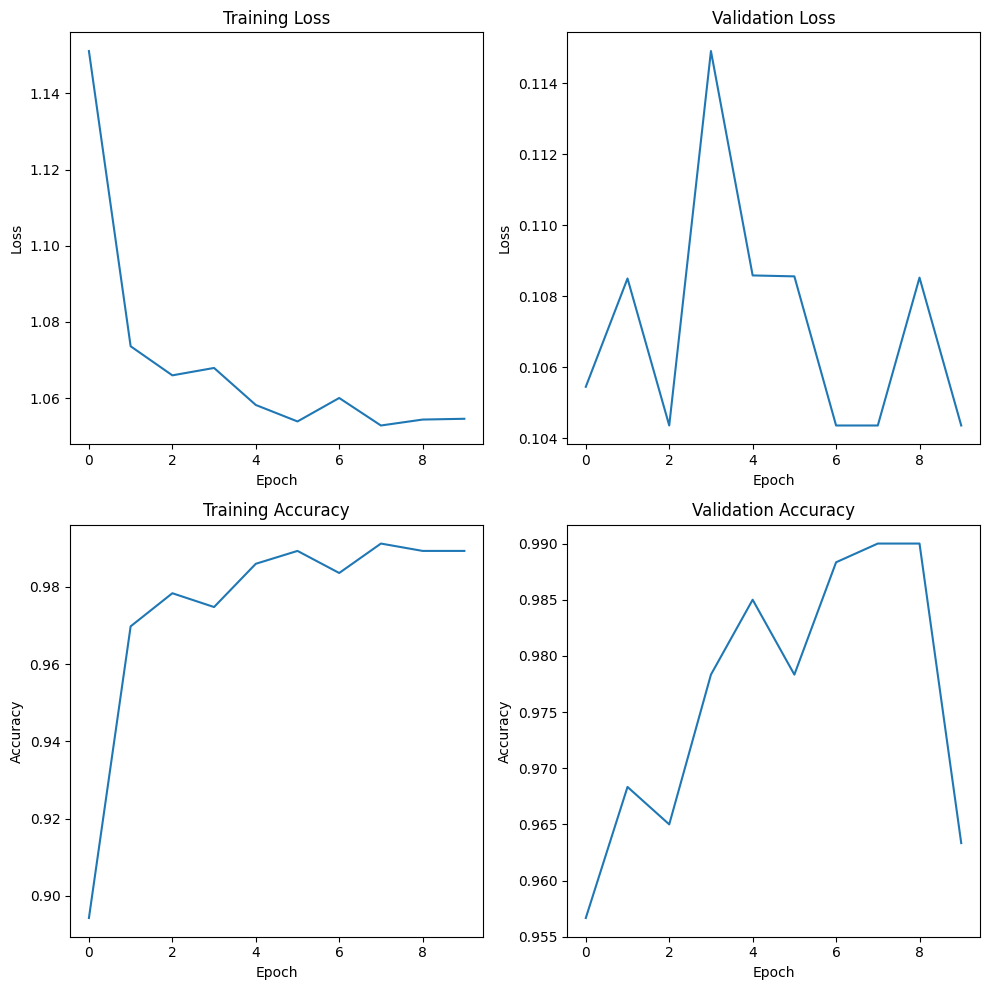

In [14]:
fig, axes = plt.subplots(2, 2, figsize = (10, 10))

axes[0, 0].plot(trainLossList)
axes[0, 0].set_title("Training Loss")
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Loss")

axes[0, 1].plot(valLossList)
axes[0, 1].set_title("Validation Loss")
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("Loss")

axes[1, 0].plot(trainAccuracyList)
axes[1, 0].set_title("Training Accuracy")
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("Accuracy")

axes[1, 1].plot(valAccuracyList)
axes[1, 1].set_title("Validation Accuracy")
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].set_ylabel("Accuracy")

plt.tight_layout()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


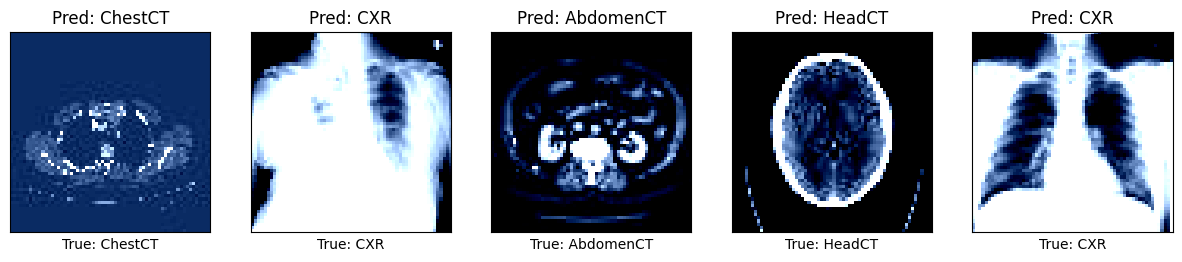

In [45]:
model.eval()
testLossList = []
testAccuracyList = []
testPredictionsList = []
testTrueLabelsList = []

# Set the number of examples to print
num_examples = 5

with torch.no_grad():
    for i, (testImages, testLabels) in enumerate(testDataLoader):
        testImages = testImages.to(device)
        testLabels = testLabels.to(device)

        testOutput = model(testImages)
        testLoss = criteria(testOutput, testLabels)
        testLossList.append(testLoss.item())

        _, predLabels = torch.max(testOutput, 1)
        correctPredictions = torch.sum(predLabels == testLabels).item()
        accuracy = correctPredictions/testLabels.size(0)
        testAccuracyList.append(accuracy)

        # Collect predictions and true labels for computing precision, recall, and F1
        testPredictionsList.extend(predLabels.cpu().numpy())
        testTrueLabelsList.extend(testLabels.cpu().numpy())

        # Print labels and images for a few examples
        if i == 0:  # Print only for the first batch
            fig, axes = plt.subplots(1, num_examples, figsize=(15, 15))
            label_names = ['HeadCT', 'Hand', 'CXR', 'AbdomenCT', 'ChestCT', 'BreastMRI']
            for j in range(num_examples):
                axes[j].imshow(np.transpose(testImages[j].cpu().numpy(), (1, 2, 0)))
                axes[j].set_xlabel(f'True: {label_names[testLabels[j].item()]}')
                axes[j].set_title(f'Pred: {label_names[predLabels[j].item()]}')
                axes[j].set_xticks([])
                axes[j].set_yticks([])
            plt.show()

# Calculate average test loss and accuracy
avgTestLoss = sum(testLossList) / len(testLossList)
avgTestAccuracy = sum(testAccuracyList) / len(testAccuracyList)

In [46]:
# Compute Precision, confusionMatrix, F1 and recall
precision = precision_score(testTrueLabelsList, testPredictionsList, average="weighted")
recall = recall_score(testTrueLabelsList, testPredictionsList, average="weighted")
f1 = f1_score(testTrueLabelsList, testPredictionsList, average="weighted")
confusionMat = confusion_matrix(testTrueLabelsList, testPredictionsList)

print(f'Test Loss: {avgTestLoss:.4f}, Test Accuracy: {avgTestAccuracy:.4f}')
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
print(f'Confusion matrix:')
print(confusionMat)

Test Loss: 1.0686, Test Accuracy: 0.9751
Precision: 0.9772, Recall: 0.9750, F1 Score: 0.9750
Confusion matrix:
[[191  25   0   0   0   0]
 [  0 197   4   0   0   0]
 [  0   1 200   0   0   0]
 [  0   0   0 211   0   0]
 [  0   0   0   0 193   0]
 [  0   0   0   0   0 178]]
